# Lifestyle and Heart Stroke

## Table of Content

[Problem](#problem)    
[Libraries](#libraries)  
[Data Understanding](#data_understanding)  
[Data Preparation](#data_preparation)    
[Modeling](#modeling)     
[Evaluation](#evaluation)   
[References](#references)  


## Problem <a class="anchor" id="problem"></a>

Can we predict any heart strokes by looking at the lifestyle of a person? In this experiment we are trying to predict whether a patient will have stroke or not based on some given attributes. By doing so we can monitor and improve lifestyle of people under risk to prevent possible problems.

## Libraries <a class="anchor" id="libraries"></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import *
from sklearn.metrics import *
from sklearn.model_selection import *

from sklearn.ensemble import RandomForestClassifier

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data Understanding<a class="anchor" id="data_understanding"></a>

This dataset is from a hackathon on Analytics Vidhya for Mckinsey data set of healthcare. It contains 11 attributes which might be related to heart strokes directly or indirectly. We have many missing values and imbalanced lables in this dataset which will take most of our time in this experiment to figure out a solution.

#### Lets import the data, quickly check the format and statistics

In [0]:
url = 'https://raw.githubusercontent.com/brainoverflow98/sklearn-lifestyle-and-heart-stroke/master/heart_storke_data.csv'
df = pd.read_csv(url)
print('Dataframe rows: {}'.format(df.shape[0]))
print('Dataframe columns: {}'.format(df.shape[1]))
df.head()

Dataframe rows: 43400
Dataframe columns: 12


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


In [0]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,43400.000000,43400.000000,43400.000000,43400.000000,43400.000000,41938.000000,43400.000000
mean,36326.142350,42.217894,0.093571,0.047512,104.482750,28.605038,0.018041
std,21072.134879,22.519649,0.291235,0.212733,43.111751,7.770020,0.133103
min,1.000000,0.080000,0.000000,0.000000,55.000000,10.100000,0.000000
25%,18038.500000,24.000000,0.000000,0.000000,77.540000,23.200000,0.000000
50%,36351.500000,44.000000,0.000000,0.000000,91.580000,27.700000,0.000000
75%,54514.250000,60.000000,0.000000,0.000000,112.070000,32.900000,0.000000
max,72943.000000,82.000000,1.000000,1.000000,291.050000,97.600000,1.000000


## Data Preparation<a class="anchor" id="data_preparation"></a>

#### Lets drop the id column and check the percentage of null values in columns

In [0]:
df.drop(['id'], axis=1, inplace=True)
df.isnull().sum()/len(df)*100

gender                0.000000
age                   0.000000
hypertension          0.000000
heart_disease         0.000000
ever_married          0.000000
work_type             0.000000
Residence_type        0.000000
avg_glucose_level     0.000000
bmi                   3.368664
smoking_status       30.626728
stroke                0.000000
dtype: float64

#### Because null value percentage is low for 'bmi' feature we can replace null values with the mean of the column.

In [0]:
df["bmi"]=df["bmi"].fillna(df["bmi"].mean())

#### There are too many missing values for 'smoking_status' so we will inspect it further after we label our categorical variables to find a solution.

#### Lets find non-numerical features and encode them as numerical values.

In [0]:
df.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

#### There are 5 non-numerical columns. For each of them we will check the unique category values and try to encode them in the best way possible. Lets start with 'gender' column. 

In [0]:
df.groupby('gender')['gender'].count()

gender
Female    25665
Male      17724
Other        11
Name: gender, dtype: int64

#### We can drop rows with 'Other' values as the number of samples are too few.

In [0]:
df.drop(df.index[df['gender'] == 'Other'], inplace = True)

#### We will create a dictionary for each category since it's easier to understans the labels and it'll be useful later on to visualize our results.

In [0]:
gender_labels = {'Female': 0, 'Male': 1}
df['gender'] = df['gender'].map(gender_labels)

#### Lets continue with  'ever_married' column.

In [0]:
df.groupby('ever_married')['ever_married'].count()

ever_married
No     15456
Yes    27933
Name: ever_married, dtype: int64

In [0]:
ever_married_labels = {'No': 0, 'Yes': 1}
df['ever_married'] = df['ever_married'].map(ever_married_labels)

#### Next, 'Residence_type' column.

In [0]:
df.groupby('Residence_type')['Residence_type'].count()

Residence_type
Rural    21638
Urban    21751
Name: Residence_type, dtype: int64

In [0]:
residence_type_labels = {'Rural': 0, 'Urban': 1}
df['Residence_type'] = df['Residence_type'].map(residence_type_labels)

#### Next, 'work_type' column.

In [0]:
df.groupby('work_type')['work_type'].count()

work_type
Govt_job          5438
Never_worked       177
Private          24827
Self-employed     6793
children          6154
Name: work_type, dtype: int64

#### We can encode 'children' and 'Never_worked' under the same value. They basically have the same practical meaning.

In [0]:
df.replace('children', 'Never_worked', inplace=True)

#### We can not use standart label encoding for 'work_type' since there are more than 2 categories and they are not contious/ordinal categories. We have to use One Hot Encoding instead.

In [0]:
df = df.join(pd.get_dummies(df['work_type']))
df.drop(['work_type'], axis=1, inplace=True)

#### And finally 'smoking_status' column. Lets start by splitting dataset into two which one of them having smoking status and one does not. 

In [0]:
# rows that does not include smoking_status information
df_nan = df[df['smoking_status'].isnull()]

In [0]:
#df_nan = df_nan.drop(['smoking_status'], axis=1)

In [0]:
# rows that include smoking_status information
df.dropna(axis=0, inplace=True)

In [0]:
print(df.groupby('smoking_status')['smoking_status'].count())

smoking_status
formerly smoked     7487
never smoked       16051
smokes              6561
Name: smoking_status, dtype: int64


#### We can assume some kind of continuity between these categorical variables since 'formerly smoked' might be considered closer to 'smokes' than 'never smoked'. So we will use Ordinal Label Encoding for these categories.

In [0]:
smoking_status_labels = {'never smoked': 0, 'formerly smoked': 1, 'smokes': 2}
df['smoking_status'] = df['smoking_status'].map(smoking_status_labels)

#### The final format of our data before trying to guess the missing 'smoking_status' values.

In [0]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,Govt_job,Never_worked,Private,Self-employed
1,1,58.0,1,0,1,1,87.96,39.2,0,0,0,0,1,0
3,0,70.0,0,0,1,0,69.04,35.9,1,0,0,0,1,0
6,0,52.0,0,0,1,1,77.59,17.7,1,0,0,0,1,0
7,0,75.0,0,1,1,0,243.53,27.0,0,0,0,0,0,1
8,0,32.0,0,0,1,0,77.67,32.3,2,0,0,0,1,0


#### We will try to find some relationship between smoking status and other features. Starting with age and gender.

In [0]:
max_age = 17

total_under_max_age = len(df[ (df['age'] < max_age)])
smoking_female = len(df[ (df['age'] < max_age) & (df['smoking_status'] != 0) & (df['gender'] == 1)])
smoking_male = len(df[ (df['age'] < max_age) & (df['smoking_status'] != 0) & (df['gender'] == 0)])
total_stroke = len(df[ (df['age'] < max_age) & (df['stroke'] == 1) ])
no_smoking_data = len(df_nan[df_nan['age'] < max_age])

print('-----STATS FOR PEOPLE UNDER AGE {}-----'.format(max_age))
print('smoking female: {}'.format(smoking_female))
print('smoking male: {}'.format(smoking_male))
print('smoker/total rate: {}'.format(((smoking_female+smoking_male)/total_under_max_age)*100))
print('total stroke cases: {}'.format(total_stroke))
print('people with no smooking data: {}'.format(no_smoking_data))

-----STATS FOR PEOPLE UNDER AGE 17-----
smoking female: 86
smoking male: 109
smoker/total rate: 17.287234042553195
total stroke cases: 0
people with no smooking data: 5936


#### Smoking status is only 17% for the people under age 17 and there are around 6000 people with missing smoking data under that age. Lets inspect it further. 

In [0]:
under_ten_with_smoking_data = len(df[ (df['age'] < 10)])
under_ten_without_smoking_data = len(df_nan[df_nan['age'] < 10])
print('people under age 10 with no smoking data: {}'.format(under_ten_without_smoking_data))
print('people under age 10 with smoking data: {}'.format(under_ten_with_smoking_data))

people under age 10 with no smoking data: 4285
people under age 10 with smoking data: 0


#### Around 4000 of the missing data is for the people under age 10. Most probably smoking percentage among these people is really low. Now we will calcute the possible smoker percentage for our dataset. We will take smoking rate as 1% for the people under age 10 and for the ages 10-17 we will take it as 17% (the value we found above).

In [0]:
print((( (no_smoking_data - under_ten_without_smoking_data) * 17 / 100) + (under_ten_without_smoking_data * 1 / 100) ) / no_smoking_data * 100)

5.4501347708894885


#### We have predicted 5% smoker rate for our dataset. This is a number we can discard. So we can categorize all these values as non smokers.

#### Before that lets check some more features to see if we can find more correlations to predict smoking status. I'll try people over age 80 and later on I'll try people who has bmi over 70.

In [0]:
min_age = 80

total_under_min_age = len(df[ (df['age'] > min_age)])
smoking_female = len(df[ (df['age'] > min_age) & (df['smoking_status'] != 0) & (df['gender'] == 1)])
smoking_male = len(df[ (df['age'] > min_age) & (df['smoking_status'] != 0) & (df['gender'] == 0)])
total_stroke = len(df[ (df['age'] > min_age) & (df['stroke'] == 1) ])

print('-----STATS FOR PEOPLE OVER AGE {}-----'.format(min_age))
print('smoking female: {}'.format(smoking_female))
print('smoking male: {}'.format(smoking_male))
print('smoker/total rate: {}'.format(((smoking_female+smoking_male)/total_under_min_age)*100))
print('total stroke cases: {}'.format(total_stroke))
print('people with no smoking data: {}'.format(len(df_nan[df_nan['age'] > min_age])))

-----STATS FOR PEOPLE OVER AGE 80-----
smoking female: 181
smoking male: 170
smoker/total rate: 49.92887624466572
total stroke cases: 64
people with no smoking data: 186


In [0]:
min_bmi = 80
total_over_min_bmi = len(df[ (df['bmi'] > min_bmi)])
smoker_over_min_bmi = len(df[ (df['bmi'] > min_bmi) & (df['smoking_status'] != 0) ])

print('-----STATS FOR PEOPLE OVER BMI {}-----'.format(min_bmi))
print('smoker/nonsmoker rate: {}'.format((smoker_over_min_bmi/total_over_min_bmi*100)))
print('people with no smoking data: {}'.format(len(df_nan[(df_nan['bmi'] > min_bmi)])))

-----STATS FOR PEOPLE OVER BMI 80-----
smoker/nonsmoker rate: 0.0
people with no smoking data: 5


#### Unfortunately there is nothing else we can find manually. Lets try to train a model using the dataset with smoking status to predict the smoking status of the other dataset.

#### Starting by splitting our data into labels and features. We are not going to split our data to train and test because cross validation functionality inside the grid search method will do that automatically for us. Also mark that we do not include 'stroke' to predict 'smoking_status' since it's the final label we want to predict.

In [0]:
labels = df['smoking_status']
features = df.drop(['stroke', 'smoking_status'], axis=1)

In [0]:
forest = RandomForestClassifier(n_jobs=-1, random_state=1)

parameter_grid = {
'min_samples_split': [400, 500],
'max_features': [6, 10]
}

skf = StratifiedKFold(n_splits=4)
grid_search = GridSearchCV(forest, parameter_grid, scoring='accuracy', cv=skf, return_train_score=True, n_jobs=-1)

grid_search.fit(features, labels)

i = grid_search.best_index_
results = pd.DataFrame(grid_search.cv_results_)

print('Accuracy: {}'.format(results.loc[i, 'mean_test_score']))

print('Standart Deviation: {}'.format(results.loc[i, 'std_test_score']))

print('Best parameters: {}'.format(results.loc[i, 'params']))

Accuracy: 0.5442042297427854
Standart Deviation: 0.0022467917250928214
Best parameters: {'max_features': 6, 'min_samples_split': 500}


#### Unfortunately our model can predict only with 55% accuracy this not enough for us to let it predict all 14000 values. Thus we will use the age correlation we found above and to categorize 6000 people as non-smokers with possbile 95% accuracy and we will be saving almost 45% of our missing data.

In [0]:
newdf = df_nan.loc[ (df_nan['age'] < 17)].copy()
newdf['smoking_status'] = 0
df = df.append(newdf, ignore_index=True)

#### Take a look at our final data format

In [0]:
print(df.shape)
df.head(5)

(36035, 14)


,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,Govt_job,Never_worked,Private,Self-employed
0,1,58.0,1,0,1,1,87.96,39.2,0,0,0,0,1,0
1,0,70.0,0,0,1,0,69.04,35.9,1,0,0,0,1,0
2,0,52.0,0,0,1,1,77.59,17.7,1,0,0,0,1,0
3,0,75.0,0,1,1,0,243.53,27.0,0,0,0,0,0,1
4,0,32.0,0,0,1,0,77.67,32.3,2,0,0,0,1,0


## Modeling<a class="anchor" id="modeling"></a>

#### Lets start by checking feature correlations to see if we can remove any low correlated features.

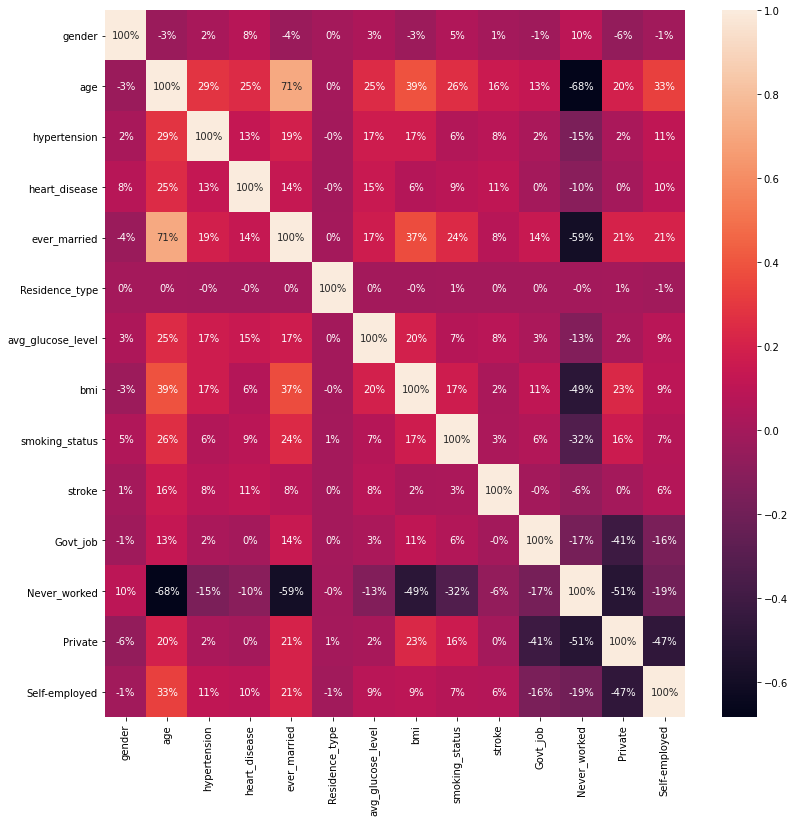

In [0]:
plt.figure(figsize=(13,13))
sns.heatmap(df.iloc[:,:].corr(), annot=True, fmt='.0%')

#### It seems like there is no feature selection we can do based on correlation. So now we will split our dataset but before that we will check if we have imbalanced label distribution.

In [0]:
labels = df['stroke']
features = df.drop(['stroke'], axis=1)

In [0]:
labels.value_counts()

0    35395
1      640
Name: stroke, dtype: int64

#### As we can see there's a huge imbalance between possitive and negative cases. So we will stratify our data while splitting it and we will try to assign higher class_weight to possitive labels while training our model.

#### Whe choosed to use RandomForestClassifier for our experiment. Because there are many categorical features in our data and decision trees in general are good at classifying with categorical features. We also want to be able to show the decision steps visually to user in order to raise awereness about the factors that can cause heart stroke. So people who have that kind of lifestyle can pay more attention to their healths.

#### We will try to keep the 'min_samples_split', 'min_samples_leaf' as high and 'max_features' as low as possible to prevent overfitting of our model. We will choose the best model based on the recall score because not missing heart stroke patients is much more important than overall  accuracy. 

In [0]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, stratify=labels, test_size = 0.2, random_state = 3)

print('Train class distribution')
print(pd.Series(y_train).value_counts())
print()
print('Test class distribution')
print(pd.Series(y_test).value_counts())

Train class distribution
0    28316
1      512
Name: stroke, dtype: int64

Test class distribution
0    7079
1     128
Name: stroke, dtype: int64


In [0]:
forest = RandomForestClassifier(class_weight={0: 1, 1: 50}, n_jobs=-1, random_state=1)

parameter_grid = {
'min_samples_split': [200, 300, 400],
'max_features': [1, 2]
}

skf = StratifiedKFold(n_splits=4)
grid_search_model = GridSearchCV(forest, parameter_grid, scoring='recall', cv=skf, return_train_score=True, n_jobs=-1)

grid_search_model.fit(x_train, y_train)

i = grid_search_model.best_index_
results = pd.DataFrame(grid_search_model.cv_results_)

print('Recall: {}'.format(results.loc[i, 'mean_test_score']))

print('Standart Deviation: {}'.format(results.loc[i, 'std_test_score']))

print('Best parameters: {}'.format(results.loc[i, 'params']))

Recall: 0.7734375
Standart Deviation: 0.036643873123620545
Best parameters: {'max_features': 2, 'min_samples_split': 400}


## Evaluation<a class="anchor" id="evaluation"></a>

#### We had a moderate result but with a low standart deviation which means that our model is stable. Now we will define some functions to plot our recal & f1 score graph. This will allow us to chose the optimal threshold value while trying to keep recal as high as possible. (You can skip this section if you want)

In [0]:
# function that turns probabilities to predictions based on the threshold
def probability_to_prediction(y_proba, threshold):
    y_pred = [1 if y >= threshold else 0 for y in y_proba] 
    return y_pred

In [0]:
# plot the precision-recall vs threshold graph to determine best threshold value
def plot_threshold(y_test, y_proba, current_threshold = 0.5):

    precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
    f1_scores = [ (2 * p * r) / (p + r) for p,r in zip(precisions, recalls) ]
    
    y_pred = probability_to_prediction(y_proba, current_threshold)   
    cr = classification_report(y_test, y_pred, output_dict=True)
    current_recall = cr['1']['recall']   
    
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.plot(thresholds, f1_scores[:-1], "r-", label="F1 Score")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    
    plt.plot(current_threshold, current_recall, '|', c='k', markersize=15)
    
    print('Recall for threshold {} is: {}'.format(current_threshold, cr['1']['recall'] ))
    print('Accuracy for threshold {} is: {}'.format(current_threshold, cr['accuracy']))

In [0]:
# score the model by applying threshold to predicted probilities
def score_model(model, y_proba, y_test, threshold = 0.5):
    
    y_pred = probability_to_prediction(y_proba, threshold) 

    print('Accuracy: {}'.format(accuracy_score(y_test, y_pred)))
    print('Confusion Matrix')
    print(confusion_matrix(y_test, y_pred))    
    print(classification_report(y_test, y_pred))
   

#### Ok, lets plot our graph.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


Recall for threshold 0.5 is: 0.765625
Accuracy for threshold 0.5 is: 0.7988067156930762


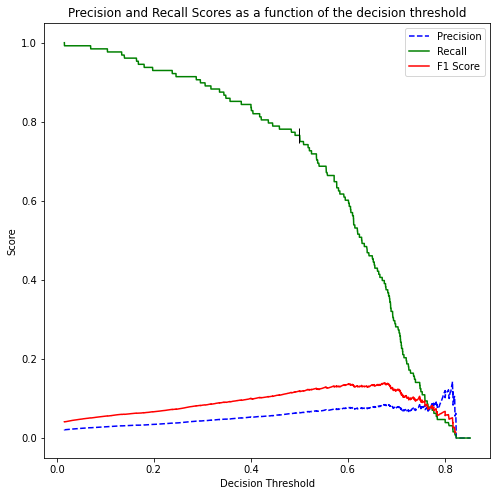

In [0]:
y_proba = grid_search_model.predict_proba(x_test)[:, 1]
optimum_threshold = 0.5
plot_threshold(y_test, y_proba, optimum_threshold)

#### Our recall increases as we decrease threshold but at the same time accuracy decreases drastically. So we will keep the threshold at default (0.5) which approxiamtely has a recall of 77% and overall accuracy of 80%.  If you want different metrics you can play with threshold value. Here is the final metrics for our model.

In [0]:
score_model(grid_search_model, y_proba, y_test, optimum_threshold)

Accuracy: 0.7988067156930762
Confusion Matrix
[[5659 1420]
 [  30   98]]
              precision    recall  f1-score   support

           0       0.99      0.80      0.89      7079
           1       0.06      0.77      0.12       128

    accuracy                           0.80      7207
   macro avg       0.53      0.78      0.50      7207
weighted avg       0.98      0.80      0.87      7207



#### Precision score for our positive cases looks low. This is due to negative cases having much largee sample number compared to positive cases. We can look at recall rate for positive cases and overall accuracy to evaluate our model. We can say numbers are not everything unless you know how to interpret them. 

#### Based on that our model performs moderately. But I would say this is expected because we didn't use many mathematical values for this experiment but rather most of them were categorical variables. At the end of the day heart strokes are not things we can always predict even using machine-learning.   

#### Here's the feature importance for the decision forest.

In [0]:
impFeatures = pd.DataFrame((grid_search_model.best_estimator_.feature_importances_) ,index=df.loc[:,df.columns!='stroke'].columns,columns=['Importance']).sort_values(by='Importance',ascending=False)
print (impFeatures)

                   Importance
age                  0.467921
avg_glucose_level    0.124936
bmi                  0.085875
ever_married         0.067078
heart_disease        0.060696
Never_worked         0.052407
hypertension         0.042925
Self-employed        0.037134
smoking_status       0.024940
Residence_type       0.009602
Private              0.009262
Govt_job             0.008643
gender               0.008579


#### As we can see age, avarge glucose level and bmi are the top 3 features that have the most impact on the outcome. Even though we worked hard on smokin_status it seems like it does not affect the outcome too much for our model :)

### <a href='https://ibb.co/jJGLNgm'>Here's</a> a tree from our random forest.

![title](https://i.ibb.co/dm6QTGF/tree1.png)

## References<a class="anchor" id="references"></a>

https://www.kaggle.com/surajdidwania/healthcare-stroke-patients-in-python/comments#673277        
https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02       
https://towardsdatascience.com/how-to-visualize-a-decision-tree-from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c   
https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65     
https://www.youtube.com/watch?v=6M2d2n-QXCc      
https://www.youtube.com/watch?v=J4Wdy0Wc_xQ     
https://www.youtube.com/watch?v=wpNl-JwwplA      


**Disclaimer!** <font color='grey'>This notebook was prepared by Halil Etka Tutkun for educational puposes. There is no guarantee on the correctness of the content provided .

If you think there is any copyright violation, please let me know
</font>